## Distributed processing to obtain a single graph from a single simulation

In [1]:
import readfof
from pyspark.sql import SparkSession
import numpy as np
import scipy.spatial as SS
import matplotlib.pyplot as plt
import math

### Spark cluster

In [2]:
spark = SparkSession.builder \
        .master("spark://master:7077")\
        .appName("CosmoSparkApplication")\
        .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/02 21:39:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
sc = spark.sparkContext

### Useful functions

In [4]:
# Read data
def read_cosmo_data(file_path):

    # Read Fof
    FoF = readfof.FoF_catalog(
        file_path,           # simulation directory
        2,                   # snapnum, indicating the redshift (z=1)
        long_ids = False,
        swap = False,
        SFR = False,
        read_IDs = False
        )

    return FoF


# Get masses and positions from FoF
def get_pos_mass(FoF):

    pos = FoF.GroupPos/1e06             # Halo positions in Gpc/h 
    mass_raw = FoF.GroupMass * 1e10     # Halo masses in Msun/h

    dim = pos.shape[0]
    pos_mass_matrix = np.hstack([pos, mass_raw.reshape(dim, 1)])

    return pos_mass_matrix


# plot a graph in 3D space
def plot_graph_3D(num, pars_file, pos, masses, edge_idx):

    fig = plt.figure(figsize=(10, 10))
    fontsize = 12

    ax = fig.add_subplot(projection ="3d")

    pos = np.array(pos, dtype=float) * 1.e3   # show in Mpc

    # Draw lines for each edge
    for (src, dst) in edge_idx: #.t().tolist():

        src = pos[int(src)].tolist()
        dst = pos[int(dst)].tolist()

        ax.plot([src[0], dst[0]], [src[1], dst[1]], zs=[src[2], dst[2]], linewidth=0.6, color='dimgrey')

    # Plot nodes
    mass_mean = np.mean(masses)
    for i,m in enumerate(masses):
            ax.scatter(pos[i, 0], pos[i, 1], pos[i, 2], s=50*m*m/(mass_mean**2), zorder=1000, alpha=0.6, color = 'mediumpurple')

    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.zaxis.set_tick_params(labelsize=fontsize)

    ax.set_xlabel('x (Mpc)', fontsize=16, labelpad=15)
    ax.set_ylabel('y (Mpc)', fontsize=16, labelpad=15)
    ax.set_zlabel('z (Mpc)', fontsize=16, labelpad=15)

    rl = '$R_{link} = 0.2$'

    pars_file = pars_file[num]

    ax.set_title(f'\tGraph n°{num}, Masses $\\geq 99.7$% percentile, {rl} Mpc \t \n \n $\\Omega_m = {float(pars_file[0]):.3f}$ \t $\\sigma_8 = {float(pars_file[1]):.3f}$', fontsize=20)

    plt.show()


# Graph object
class graph:

    def __init__(self, node_f, pos, sim_pars, glob_f, edge_idx, edge_f):
        
        self.node_f = node_f
        self.pos = pos
        self.sim_pars = sim_pars
        self.glob_f = glob_f
        self.edge_idx = edge_idx
        self.edge_f = edge_f

### Read simulation file and parallelize data

In [5]:
# simulations parameter
sim_pars_file = np.loadtxt("/mnt/cosmo_GNN/latin_hypercube_params.txt", dtype=float)

# read file and get positions and masses
file_path = "/mnt/cosmo_GNN/Data/" + str(8)
test_FoF = read_cosmo_data(file_path)
pos_mass_array = get_pos_mass(test_FoF)

# mass cut
cut = np.quantile(pos_mass_array[:, 3], 0.997)

# parallelize and filter by mass
pos_mass_rdd = sc.parallelize(pos_mass_array)\
                 .filter(lambda el: el[3] >= cut)

$\rightarrow$ here we may add something to be benchmarked $\leftarrow$

### Clustering phase to get linked halos

In [6]:
# masses rdd
mass_rdd = pos_mass_rdd.map(lambda x: x[3])

# positions rddc
pos_rdd = pos_mass_rdd.map(lambda el: el[:3])

# indexed position rdd
idx_pos_rdd = pos_rdd.zipWithIndex()

# cartesian product between the positions rdd and itself (to obtain all the possible pairs)
cartesian_rdd = idx_pos_rdd.cartesian(idx_pos_rdd)

# compute differences between every pair
diff_rdd = cartesian_rdd.map(lambda x: (x[0][1], x[1][1], np.abs(x[0][0] - x[1][0])))

# compute distances between every pair
pairs_dist_rdd = diff_rdd.map(lambda x: (x[0], x[1], np.linalg.norm(x[2])))

# pairs and distances rdd filtered
linked_pairs_dist_rdd = pairs_dist_rdd.filter(lambda x: x[2] <= 0.2)
# linked_pairs_dist_rdd = pairs_dist_rdd.filter(lambda x: x[0] < x[1] and x[2] <= 0.2)

# pairs rdd
pairs_rdd = linked_pairs_dist_rdd.map(lambda x: (x[0], x[1]))

# distances rdd 
distances_rdd = linked_pairs_dist_rdd.map(lambda x: x[2])

24/09/02 21:39:45 WARN TaskSetManager: Stage 0 contains a task of very large size (3215 KiB). The maximum recommended task size is 1000 KiB.


In [7]:
# pairs array
pairs_array = np.array(pairs_rdd.collect())

24/09/02 21:39:48 WARN TaskSetManager: Stage 1 contains a task of very large size (3215 KiB). The maximum recommended task size is 1000 KiB.


In [8]:
pairs_array.shape

(6734, 2)

### Graph 3D plot

24/09/02 21:39:54 WARN TaskSetManager: Stage 2 contains a task of very large size (3215 KiB). The maximum recommended task size is 1000 KiB.
24/09/02 21:39:54 WARN TaskSetManager: Stage 3 contains a task of very large size (3215 KiB). The maximum recommended task size is 1000 KiB.
24/09/02 21:39:54 WARN TaskSetManager: Stage 4 contains a task of very large size (3215 KiB). The maximum recommended task size is 1000 KiB.


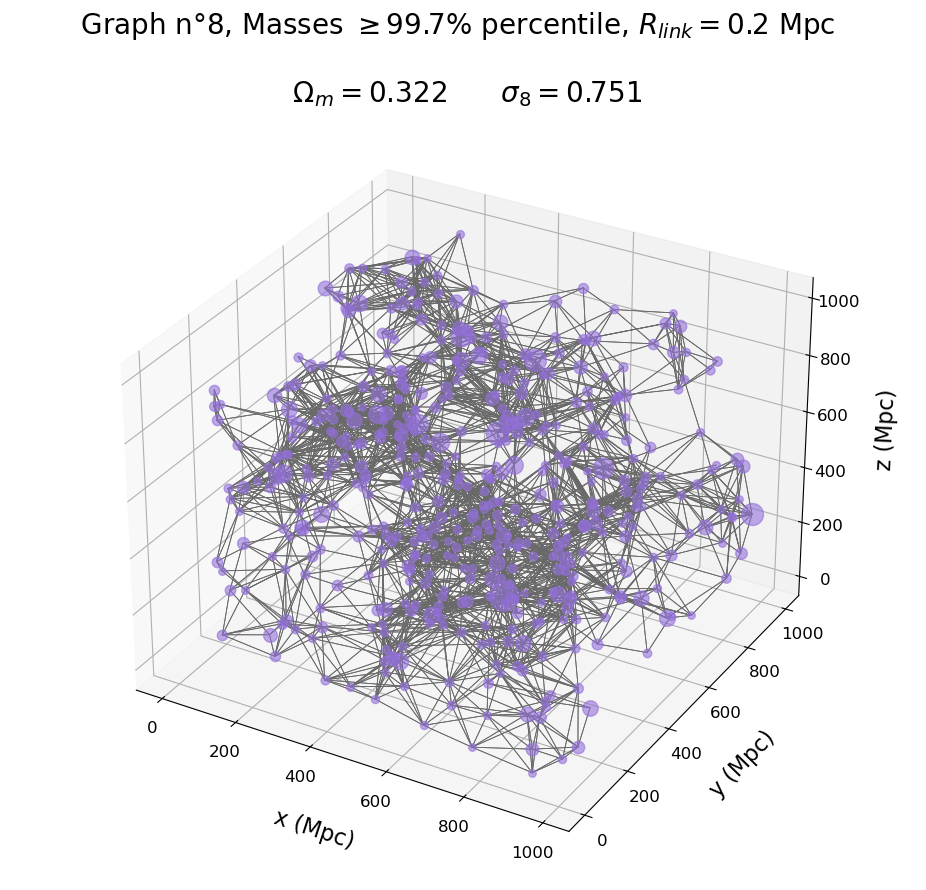

In [9]:
# plot the graph in 3D space

pos_rdd_plot = pos_rdd.collect()
mass_rdd_plot = mass_rdd.collect()
pairs_rdd_plot = pairs_rdd.collect()

plot_graph_3D(8, sim_pars_file, pos_rdd_plot, mass_rdd_plot, pairs_rdd_plot)

### Retrieving edge features

In [16]:
# filter linked positions
pos_rdd_filtered = cartesian_rdd.filter(lambda x: [x[0][1], x[1][1]] in pairs_array.tolist())

# calculate halos centroid position
halo_centroid = pos_rdd.mean()

24/09/02 21:43:14 WARN TaskSetManager: Stage 10 contains a task of very large size (3215 KiB). The maximum recommended task size is 1000 KiB.


In [17]:
# distance between each pair element wrt halos centroid (normalized)
d_row = pos_rdd_filtered.map(lambda x: x[0][0]).map(lambda x: x - halo_centroid).map(lambda x: x/np.linalg.norm(x))
d_col = pos_rdd_filtered.map(lambda x: x[1][0]).map(lambda x: x - halo_centroid).map(lambda x: x/np.linalg.norm(x))

# pair distance coordinates
diff_filtered_rdd = pos_rdd_filtered.map(lambda x: x[0][0]-x[1][0])

# get cosines
cos1 = d_row.zip(d_col).map(lambda x: np.dot(x[0].T, x[1]))
cos2 = d_row.zip(diff_filtered_rdd).map(lambda x: np.dot(x[0].T, x[1]))

# normalized distance between pairs (by linking radius)
distances_rdd_norm = distances_rdd.map(lambda x: x/0.2)

# get edge attributes
cosines_rdd = cos1.zip(cos2)
edge_feat_rdd = cosines_rdd.zip(distances_rdd_norm).map(lambda x: [x[0][0], x[0][1], x[1]])

In [ ]:
edge_feat_rdd.collect()

### Global feature and graph object creation

In [ ]:
# global feature
u = math.log10(mass_rdd.count())

# graph object
graph_8 = graph(mass_rdd.collect(), pos_rdd.collect(), sim_pars_file[8], u, pairs_array, edge_feat_rdd.collect())

### Stopping Spark Context and Spark Master

In [12]:
sc.stop()
spark.stop()